# Template Matching

Use the events detected with the backprojection method and previously formatted in `6_build_template_database.ipynb` as template events for a matched-filter search.

In [1]:
import os
# choose the number of threads you want to limit the computation to
n_CPUs = 24
os.environ["OMP_NUM_THREADS"] = str(n_CPUs)

import BPMF
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from BPMF.data_reader_examples import data_reader_mseed
from time import time as give_time


In [2]:
# %config InlineBackend.figure_formats = ["svg"]

In [3]:
# PROGRAM PARAMETERS
TEMPLATE_DB = "template_db"
MATCHED_FILTER_DB = "matched_filter_db"
PATH_MF = os.path.join(BPMF.cfg.OUTPUT_PATH, MATCHED_FILTER_DB)
DATA_FOLDER = "preprocessed_2_12"
NETWORK_FILENAME = "network.csv"

# data reading parameter
DATA_READER = data_reader_mseed

# TEMPLATE MATCHING PARAMETERS
# MIN_INTEREVENT_TIME_SEC: minimum inter-event time, in seconds, allowed between 2 detections,
#                          keep the highest CC otherwise
MIN_INTEREVENT_TIME_SEC = 5.0
# THRESHOLD_WINDOW_DUR_SEC: duration of the sliding window, in seconds, over which the time-dependent
#                           detection threshold is computed
THRESHOLD_WINDOW_DUR_SEC = 1800.0
# OVERLAP: overlap, between 0 and 1, between sliding windows. This parameter is mainly here for legacy
#          reason but in the later versions of BPMF it does not seem necessary to use overlaping windows.
OVERLAP = 0.0
# THRESHOLD_TYPE: 'rms' or 'mad'. Use a time-dependent threshold based on `BPMF.cfg.N_DEV_MF_THRESHOLD` times
#                 the rms or the mad. Mad stands for Median absolute deviation and is equal to 1.48xRMS for
#                 the normal distribution.
THRESHOLD_TYPE = "rms"
# WEIGHT_TYPE: 'simple'. BPMF does not support any other weight types for now.
WEIGHT_TYPE = "simple"
# DEVICE: 'gpu' or 'cpu'. Use 'gpu' if you have Nvidia GPUs and have compiled fast_matched_filter and beampower
#         for you GPUs.
DEVICE = "cpu"
# MAX_MEMORY_GB: The maximum memory, in gigabytes, that BPMF can use at once. When running a matched-filter search,
#                computing a correlation coefficient time series for each template event can be very memory consuming.
#                Thus, a memory efficient trick is to loop over small batches of the template database. BPMF automatically
#                determines the appropriate number of templates per batch to satisfy this memory constraint.
MAX_MEMORY_GB = 32.0  # Gb
# SANITY_CHECK: If true, test the gaussianity of the correlation coefficient time series. A problem-free CC time series
#               is expected to be mostly gaussian distributed. If large deviations are observed, we simply discard the
#               CC time series for the given template.
SANITY_CHECK = True
# MAX_KURTOSIS: If SANITY_CHECK is True, the CC time series with kurtosis higher than MAX_KURTOSIS are discarded.
MAX_KURTOSIS = 100
# N_SELECTED_STATIONS: For large seismic networks, limit the number of stations over which the matched-filter search
#                      is run to the N_SELECTED_STATIONS closest (or best snr) to a given template.
N_SELECTED_STATIONS = 10
# MIN_CHANNELS: If the data availability for a given template and a given day drops below MIN_CHANNELS channels, the
#               template is not used for the matched-filter search.
MIN_CHANNELS = 6
# MIN_STATIONS: If the data availability for a given template and a given day drops below MIN_STATIONS stations, the
#               template is not used for the matched-filter search.
MIN_STATIONS = 3
# NORMALIZE: If True, the continuous waveforms are normalized by their rms before starting the matched-filter search.
#            This avoids issues with numerical imprecisions when dealing with small numbers (note that all the algebra is
#            done in float32 on GPUs and, generally, in BPMF).
NORMALIZE = True
# PHASE_ON_COMP_PEAK_AMP: dictionary defining which phase we use at a given component to extract the event's peak amplitude
PHASE_ON_COMP_PEAK_AMP = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "P"}
# OFFSET_WIN_PEAK_AMP_SEC: The offset, in seconds, between the phase pick and the beginning of the window
#                          used to extract the event peak amplitude at a given channel.
OFFSET_WIN_PEAK_AMP_SEC = 1.
# DURATION_WIN_PEAK_AMP_SEC: The duration, in seconds, of the window used to extract the event
#                            peak amplitude at a given channel.
DURATION_WIN_PEAK_AMP_SEC = 3.


## Read the template database

In [4]:
# read the network metadata
net = BPMF.dataset.Network(NETWORK_FILENAME)
net.read()


In [5]:
template_filenames = glob.glob(
    os.path.join(BPMF.cfg.OUTPUT_PATH, TEMPLATE_DB, "template*")
)
template_filenames.sort()


In [6]:
# initialize the template group
t_start = give_time()
template_group = BPMF.dataset.TemplateGroup.read_from_files(template_filenames, net)
# read and normalize waveforms
template_group.read_waveforms()
template_group.normalize(method="rms")
t_end = give_time()
print(f"{t_end-t_start:.2f}sec to read the {template_group.n_templates}" " templates.")


0.73sec to read the 13 templates.


## Initialize the `BPMF.similarity_search.MatchedFilter` instance.

In [7]:
# initialize the MatchedFilter object
MF = BPMF.similarity_search.MatchedFilter(
    template_group,
    normalize=NORMALIZE,
    threshold_type=THRESHOLD_TYPE,
    max_memory=MAX_MEMORY_GB,
    max_workers=n_CPUs,
    max_kurto=MAX_KURTOSIS,
    min_channels=MIN_CHANNELS,
    min_stations=MIN_STATIONS,
    offset_win_peak_amp_sec=OFFSET_WIN_PEAK_AMP_SEC,
    duration_win_peak_amp_sec=DURATION_WIN_PEAK_AMP_SEC,
    phase_on_comp_peak_amp=PHASE_ON_COMP_PEAK_AMP,
)

## Load the data

In [ ]:
date_list = net.datelist()
print("Days to process: ", date_list)

Days to process:  DatetimeIndex(['2012-07-26 00:00:00+00:00'], dtype='datetime64[ns, UTC]', freq='D')


In [9]:
# this could be written as a loop:
#for date in date_list:
date = date_list[0]
date = pd.Timestamp(date)
date_str = date.strftime("%Y-%m-%d")
data_root_folder = os.path.join(BPMF.cfg.INPUT_PATH, str(date.year), date.strftime("%Y%m%d"))
t_start_day = give_time()
print(f"Processing {date_str}")
# -------------------------------------------
#            Load the data
# -------------------------------------------
where = os.path.join(BPMF.cfg.INPUT_PATH, str(date.year), date.strftime("%Y%m%d"))
data = BPMF.dataset.Data(
    date,
    where,
    data_reader_mseed,
    duration=24.0 * 3600.0,
    sampling_rate=BPMF.cfg.SAMPLING_RATE_HZ,
)
data.read_waveforms(data_folder=DATA_FOLDER)
print(data.traces.__str__(extended=True))
# get the data in a numpy.ndarray
data_arr = data.get_np_array(net.stations)

Processing 2012-07-26


24 Trace(s) in Stream:
YH.DE07..BHN | 2012-07-26T00:00:00.000000Z - 2012-07-27T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.DC07..BHN | 2012-07-26T00:00:00.000000Z - 2012-07-27T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.DC08..BHZ | 2012-07-26T00:00:00.000000Z - 2012-07-27T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.DE08..BHZ | 2012-07-26T00:00:00.000000Z - 2012-07-27T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.SPNC..BHZ | 2012-07-26T00:00:00.000000Z - 2012-07-27T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.DC06..BHZ | 2012-07-26T00:00:00.000000Z - 2012-07-27T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.SAUV..HHZ | 2012-07-26T00:00:00.000000Z - 2012-07-27T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.DC07..BHE | 2012-07-26T00:00:00.000000Z - 2012-07-27T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.DE07..BHE | 2012-07-26T00:00:00.000000Z - 2012-07-27T00:00:00.000000Z | 25.0 Hz, 2160001 samples
YH.DD06..BHZ | 2012-07-26T00:00:00.000000Z - 2012-07-27T00:00:00.000000Z | 25

You can experiment whether you want to use the `N_SELECTED_STATIONS` closest stations or the best SNR stations. In an environment like a fault zone, the ray paths to the closest stations may go through highly damaged rock and produce noisy waveforms. Thus, using the best SNR stations should provide better performances in general.

In [10]:
# compute data availability
data.set_availability(net.stations)
# re-arrange selected stations on each template
# template_group.n_closest_stations(
#         N_SELECTED_STATIONS,
#         available_stations=data.availability.index[data.availability]
#         )
template_group.n_best_SNR_stations(
        N_SELECTED_STATIONS,
        available_stations=data.availability.index[data.availability]
        )
# attach the `Data` instance to the `MatchedFilter` instance
MF.set_data(data)

## Run the matched-filter search

In [11]:
# we use verbose = 1 for this example but you might want to use verbose = 0 for large-scale applications
detections = MF.run_matched_filter_search(
    MIN_INTEREVENT_TIME_SEC,
    weight_type=WEIGHT_TYPE,
    device=DEVICE,
    threshold_window_dur=THRESHOLD_WINDOW_DUR_SEC,
    overlap=OVERLAP,
    sanity_check=SANITY_CHECK,
    verbose=1,
)

Template 0 detected 38 events.
Template 1 detected 31 events.
Template 10 detected 28 events.
Template 11 detected 1 events.
Template 12 detected 1 events.
Template 2 detected 2 events.
Template 3 detected 21 events.
Template 4 detected 15 events.
Template 5 detected 14 events.
Template 6 detected 38 events.
Template 7 detected 5 events.
Template 8 detected 1 events.
Template 9 detected 1 events.
Total time spent on computing CCs: 5.29sec
Total time spent on finding detections: 0.48sec


## Plot the detected events

In [12]:
# choose the template you want to plot
TEMPLATE_ID = 0

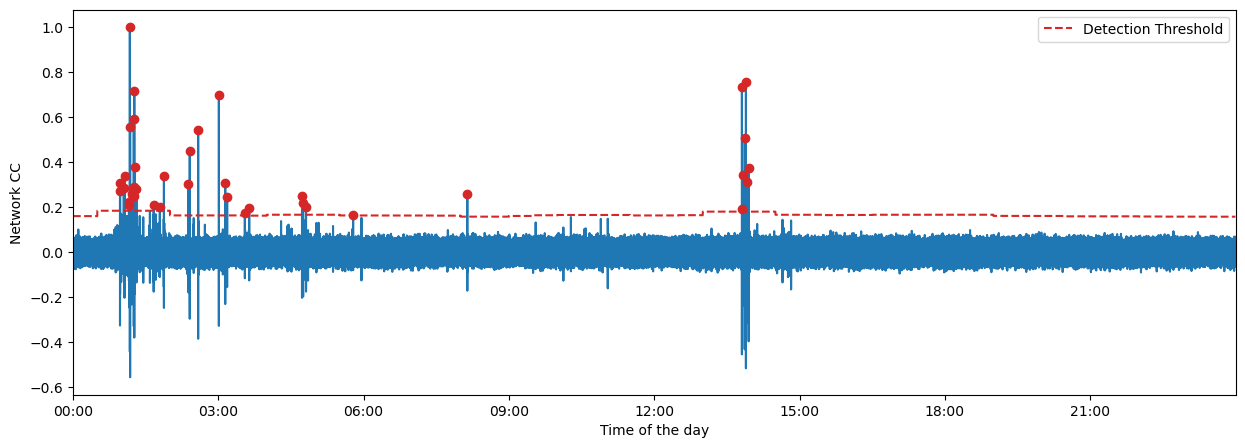

In [13]:
fig = MF.plot_cc(TEMPLATE_ID, figsize=(15, 5))

In [14]:
# read the detected events' waveforms for plotting purposes
# note: on a large-scale application, we generally just want to save the detected events' metadata to the output database

# event extraction parameters

# PHASE_ON_COMP: dictionary defining which moveout we use to extract the waveform
PHASE_ON_COMP = {"N": "S", "1": "S", "E": "S", "2": "S", "Z": "P"}
# OFFSET_PHASE: dictionary defining the time offset taken before a given phase
#               for example OFFSET_PHASE["P"] = 1.0 means that we extract the window
#               1 second before the predicted P arrival time
OFFSET_PHASE = {"P": 1.0, "S": 4.0}
# TIME_SHIFTED: boolean, if True, use moveouts to extract relevant windows
TIME_SHIFTED = True

t1 = give_time()
for i in range(len(detections[TEMPLATE_ID])):
    detections[TEMPLATE_ID][i].read_waveforms(
        BPMF.cfg.TEMPLATE_LEN_SEC,
        phase_on_comp=PHASE_ON_COMP,
        offset_phase=OFFSET_PHASE,
        time_shifted=TIME_SHIFTED,
        data_folder=DATA_FOLDER,
    )
t2 = give_time()
print(
    f"{t2-t1:.2f}sec to read the waveforms for all {len(detections):d} detections."
)

8.11sec to read the waveforms for all 13 detections.


Using `BPMF.similarity.MatchedFilter.plot_detection` method, we plot the waveforms of a detected event (black) on top of which we plot the template waveforms (red). The location in time of the detected event is also shown by an arrow on the CC time series (top plot).

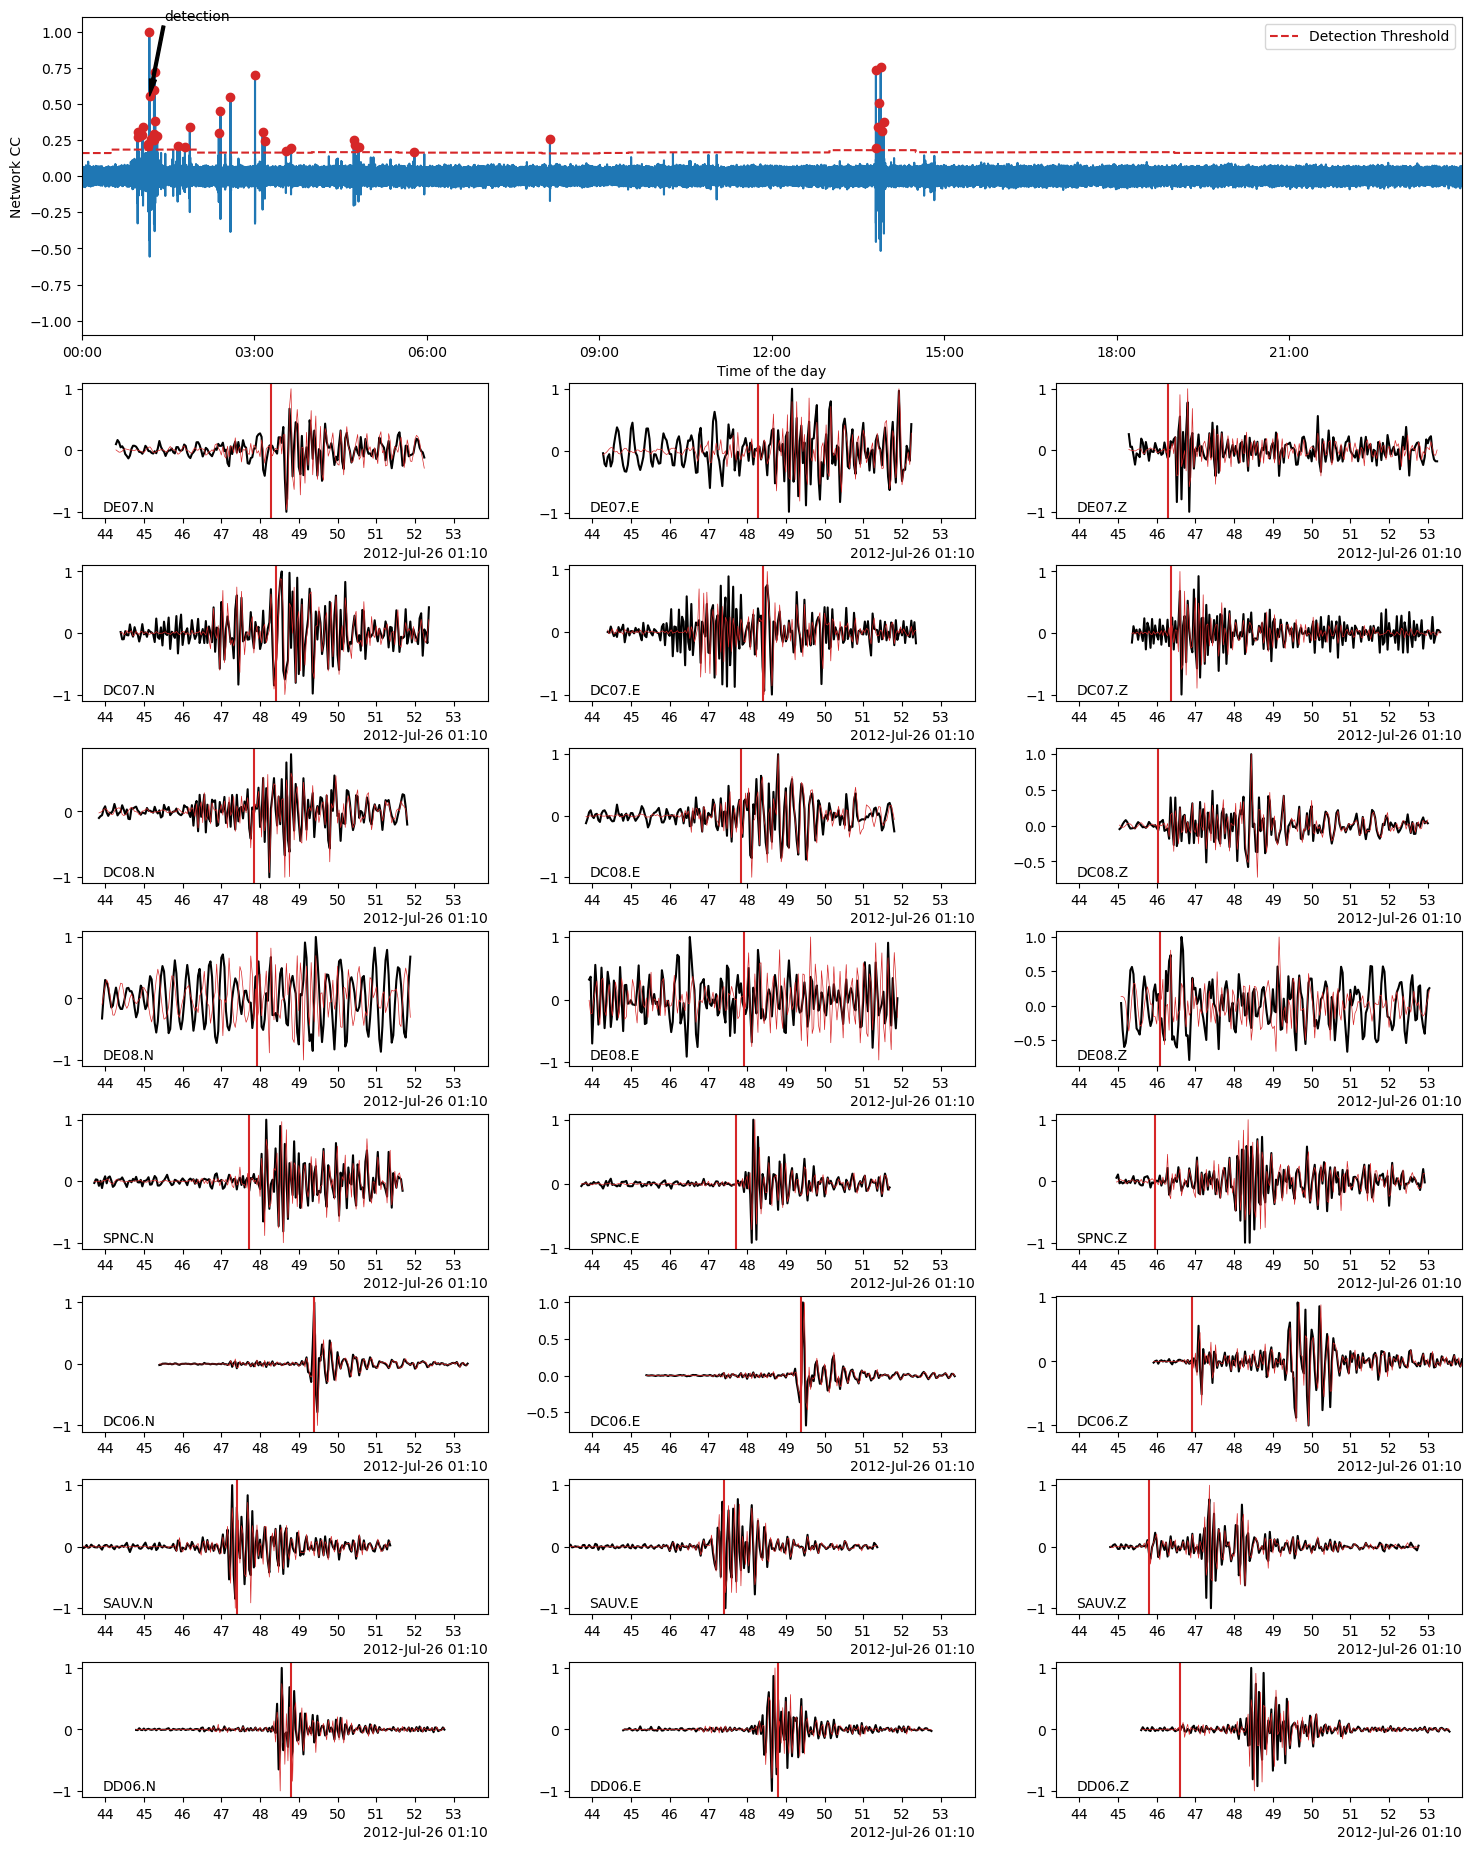

In [15]:
# choose the event idx you want to plot
EVENT_IDX = 7
fig = MF.plot_detection(
    detections[TEMPLATE_ID][EVENT_IDX],
    figsize=(15, 20),
)


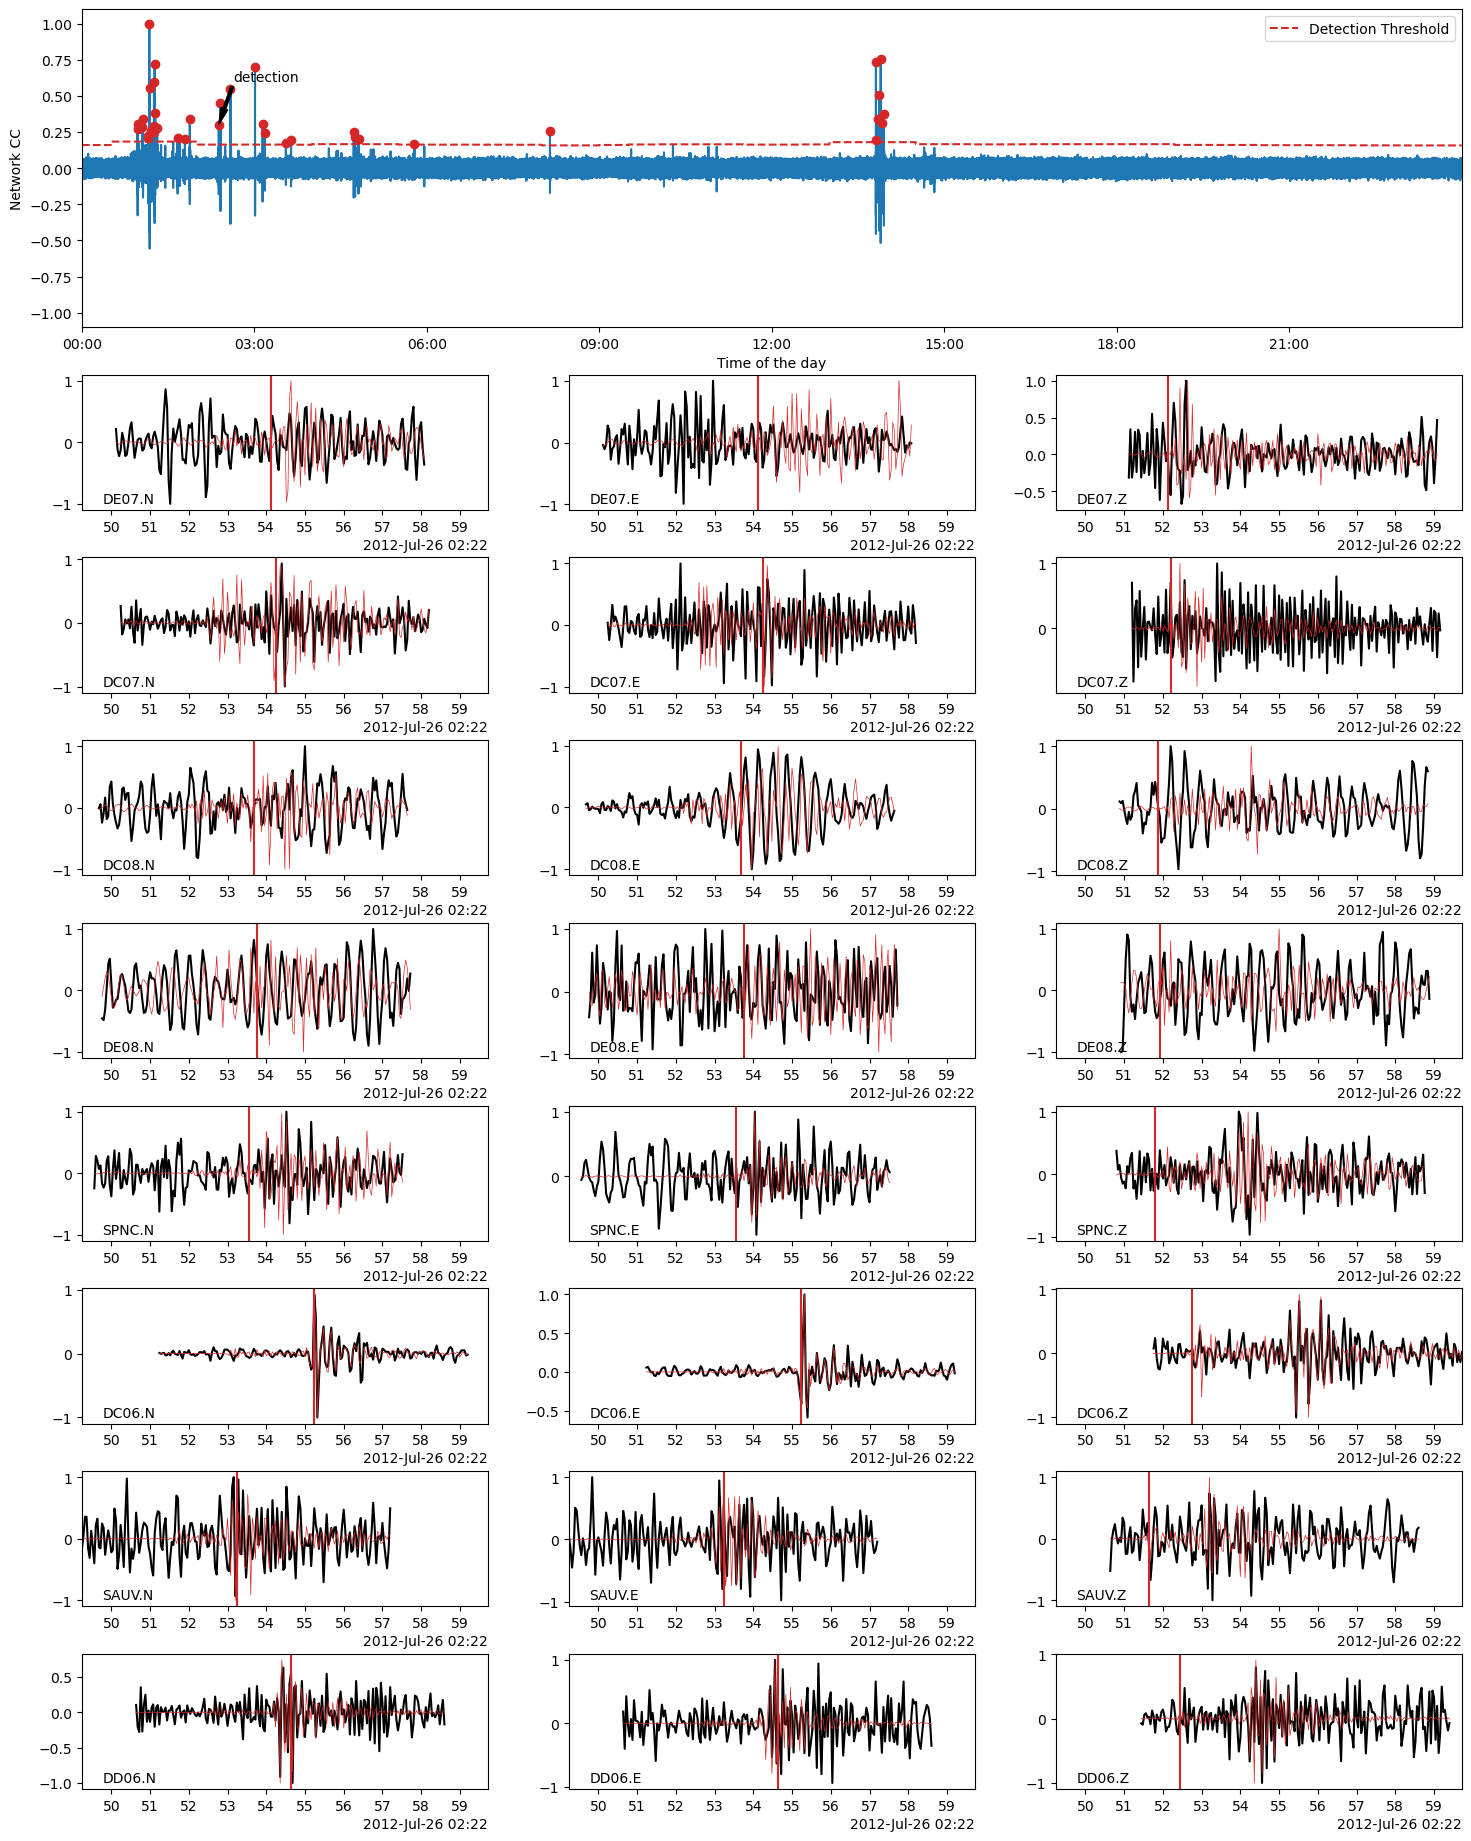

In [16]:
# choose the event idx you want to plot
EVENT_IDX = 18
fig = MF.plot_detection(
    detections[TEMPLATE_ID][EVENT_IDX],
    figsize=(15, 20),
)


## Save the detected events to database

Here, we save the detected events' metadata in a hdf5 file that is unique to each template. Each detected event is stored in a hdf5 `Group` which is identified by a string with its origin time.

In [17]:
# save detections in their parent-template file
if not os.path.isdir(PATH_MF):
    os.mkdir(PATH_MF)
n_total = 0
t_writing_start = give_time()
# serial version
for tid in detections.keys():
    parent_tp_filename = f"detections_template{tid}.h5"
    fullpath = os.path.join(PATH_MF, parent_tp_filename)
    # output_file = h5.File(fullpath, mode='a')
    for i in range(len(detections[tid])):
        tid = detections[tid][i].aux_data["tid"]
        gid = detections[tid][i].origin_time.strftime("%Y-%m-%dT%H:%M:%S")
        detections[tid][i].write(
            parent_tp_filename, db_path=PATH_MF, gid=gid
        )  # , hdf5_file=output_file)
        n_total += 1
t_writing_end = give_time()
print(f"Writing took {t_writing_end-t_writing_start:.2f}sec.")


Writing took 25.43sec.


We are almost done! Note that neighboring templates are very likely to detect some events in common. Thus, to build a meaningful earthquake catalog with no (or, more realistically, few) multiple detections of the same events, we still need to clean up the database (see next notebook).